# Difftest Results

Import prereqs and connect to results database:

In [15]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import OrderedDict
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import viz

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

Summary of testing results:

In [29]:
def get_device_stats(s, tables, testbed_id, no_opt):
    devname = device_str(s.query(Testbed).filter(Testbed.id == testbed_id).first().device)
    num_results = results_in_order(s, tables, testbed_id, no_opt,
                                   sql.sql.func.count(tables.results.id)).scalar()

    if num_results:
        _, total_time = results_in_order(s, tables, testbed_id, no_opt, 
                                         tables.results.id, tables.meta.cumtime, reverse=True).first()
    else:
        total_time = 0

    print(f"\r\033[1K{tables.name} {devname}",
          "no-opt" if no_opt else "opt",
          f"results: {num_results} time: {total_time:.0f}s", end="")
    return num_results, total_time


def get_device_overview(s, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    
    clsmith_noopt_results, clsmith_noopt_time = get_device_stats(s, CLSMITH_TABLES, testbed_id, True)
    clsmith_results, clsmith_time = get_device_stats(s, CLSMITH_TABLES, testbed_id, False)

    clgen_noopt_results, clgen_noopt_time = get_device_stats(s, CLGEN_TABLES, testbed_id, True)
    clgen_results, clgen_time = get_device_stats(s, CLGEN_TABLES, testbed_id, False)
    
    r1 = OrderedDict()
    r1["Device"] = device_str(testbed.device)
    r1["±"] = "-"
    r1["CLSmith time"] = clsmith_noopt_time
    r1["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_noopt_time / 3600)
    r1["CLSmith results"] = clsmith_noopt_results
    r1["CLgen time"] = clgen_noopt_time
    r1["CLgen time (hrs)"] = "{:.1f}h".format(clgen_noopt_time / 3600)
    r1["CLgen results"] = clgen_noopt_results
    
    r2 = OrderedDict()
    r2["Device"] = device_str(testbed.device)
    r2["±"] = "+"
    r2["CLSmith time"] = clsmith_time
    r2["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_time / 3600)
    r2["CLSmith results"] = clsmith_results
    r2["CLgen time"] = clgen_time
    r2["CLgen time (hrs)"] = "{:.1f}h".format(clgen_time / 3600)
    r2["CLgen results"] = clgen_results
    
    return r1, r2


rows = []
with Session(commit=False) as s:
    for config_id, testbed_id in CONFIGURATIONS:
        rows += get_device_overview(s, testbed_id)
overview_table = pd.DataFrame(rows)
overview_table

CLgen Oclgrind Simulator opt results: 89263 time: 200130s38s8s11177s93ss

,Device,±,CLSmith time,CLSmith time (hrs),CLSmith results,CLgen time,CLgen time (hrs),CLgen results
0,GeForce GTX 1080,-,223631.0,62.1h,20002,256232.0,71.2h,90977
1,GeForce GTX 1080,+,240643.0,66.8h,20002,261894.0,72.7h,86537
2,GeForce GTX 780,-,198643.0,55.2h,21000,212845.0,59.1h,109312
3,GeForce GTX 780,+,205033.0,57.0h,21000,182948.0,50.8h,88037
4,Intel HD Haswell GT2,-,215423.0,59.8h,7957,178577.0,49.6h,144984
5,Intel HD Haswell GT2,+,444002.0,123.3h,16087,179994.0,50.0h,144984
6,Intel E5-2620 v4,-,206300.0,57.3h,21000,229618.0,63.8h,140206
7,Intel E5-2620 v4,+,190422.0,52.9h,21000,213613.0,59.3h,140206
8,Intel E5-2650 v2,-,201941.0,56.1h,21001,229141.0,63.7h,121930
9,Intel E5-2650 v2,+,241561.0,67.1h,21000,212634.0,59.1h,110330


## Schedule

Calculate schedule of remaining jobs which must be ran to meet a minimum time limit.

In [30]:
TIME_LIMIT = 48 * 3600

schedule = []
for _, row in overview_table.iterrows():
    for source in ["CLSmith", "CLgen"]:
        if row[f"{source} time"] < TIME_LIMIT:
            d = OrderedDict()
            d["Device"] = row["Device"]
            d["±"] = row["±"]
            d["Job"] = source
            d["Remaining time"] = (TIME_LIMIT - row[f"{source} time"])
            d["Remaining time (hours)"] = "{:.1f}h".format((TIME_LIMIT - row[f"{source} time"]) / 3600)
            schedule.append(d)

schedule = pd.DataFrame(schedule).sort_values(by="Remaining time", ascending=False)
schedule

KeyError: 'Remaining time'

## Testing Time

Plot total testing time of each configuration.

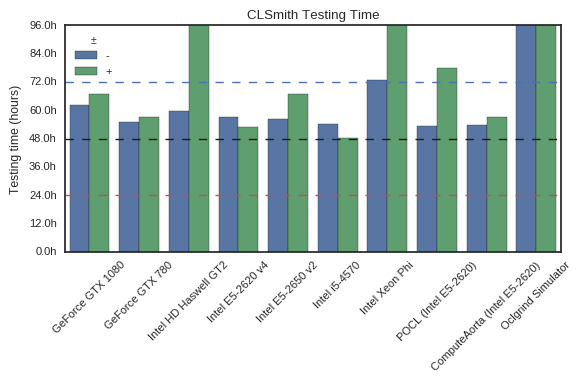

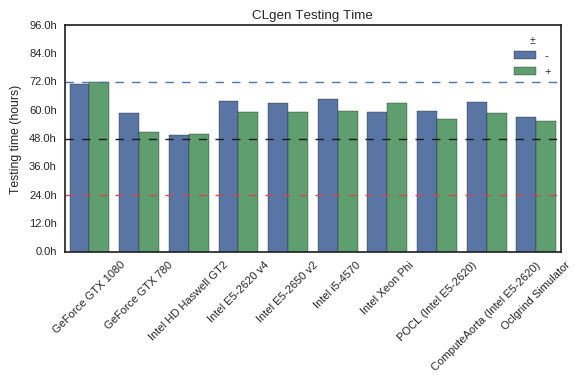

In [19]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_testing_time(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.set_ylim((0, 96 * 3600))
    plt.yticks(np.arange(0, 100 * 3600, 12 * 3600))
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}h".format(x / 3600)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    plt.axhline(y=24 * 3600, color="r", lw=1, linestyle="--")
    plt.axhline(y=48 * 3600, color="k", lw=1, linestyle="--")
    plt.axhline(y=72 * 3600, color="b", lw=1, linestyle="--")

    viz.finalise(figsize=(6, 4))

plot_testing_time(overview_table, "CLSmith time", "CLSmith Testing Time")
plot_testing_time(overview_table, "CLgen time", "CLgen Testing Time")

## Number of Results

Plot the number of results for each configuration.

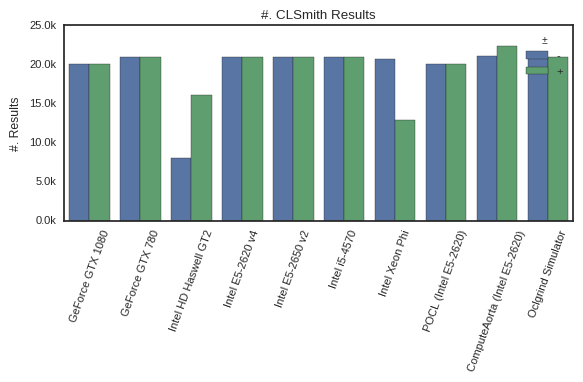

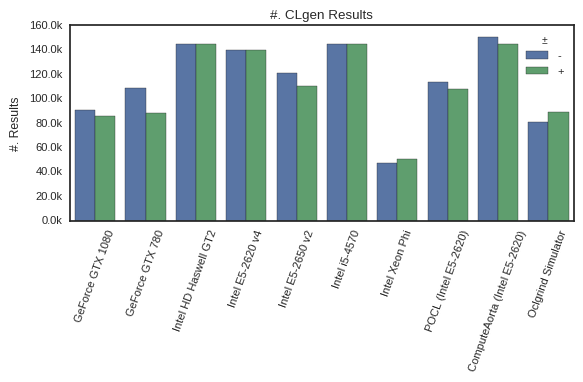

In [20]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_num_results(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}k".format(x / 1000)))
    ax.set_ylabel("#. Results")
    plt.title(title)

    viz.finalise(figsize=(6, 4))

plot_num_results(overview_table, "CLSmith results", "#. CLSmith Results")
plot_num_results(overview_table, "CLgen results", "#. CLgen Results")

## Testbeds

In [28]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict


def get_platform_stats(s, testbed: Testbed):
    num_submitted = s.query(sql.sql.func.count(BugReport.id)).filter(BugReport.testbed_id == testbed.id).scalar() or 0

    # Total time running CLgen tests:
    clgen_time = sum(overview_table.loc[overview_table["Device"] == device_str(testbed.device)]["CLgen time"].values)
    # print(device_str(testbed.device), "CLgen", clgen_time)
    
    # Total time running CLgen reductions:
    reduction_time = s.query(sql.sql.func.sum(CLgenReduction.runtime)).join(CLgenResult)\
        .filter(CLgenResult.testbed_id == testbed.id).scalar() or 0
    # print(device_str(testbed.device), "reduction", reduction_time)
    
    # Total time from unstructured testing results:
    def get_runtime(table):
        return s.query(sql.sql.func.sum(table.runtime)).filter(table.testbed_id == testbed.id).scalar() or 0
    other_runtimes = sum(get_runtime(table) for table in [coCLgenResult, cl_launcherCLgenResult])
    # print(device_str(testbed.device), "other", other_runtimes)

    return (
        clgen_time + reduction_time + other_runtimes,
        num_submitted,
    )


def get_row(s, config_id, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Platform"] = platform_str(testbed.platform)
    d["Device"] = device_str(testbed.device)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    runtime, submitted = get_platform_stats(s, testbed)
    d["Testing time"] = "{:.0f} hours".format(round(runtime / 3600))
    d["B.R. Submitted"] = submitted
    return d

with Session(commit=False) as s:
    rows = [get_row(s, *x) for x in CONFIGURATIONS]
table = pd.DataFrame(rows)
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    print(f"""\
\\begin{{tabular}}{{ cllllll | rr }}
\\toprule
\\textbf{{\\#. }} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & \\textbf{{OpenCL}} & 
\\textbf{{Operating system}} & \\textbf{{Device Type}} & \\textbf{{Testing time}} & \\textbf{{Bugs Submitted}} \\\\
\\midrule""", file=outfile)
    for row in rows:
        print(" & ".join([str(x) for x in row.values()]), "\\\\", file=outfile)
    print(f"""
\\bottomrule
\\end{{tabular}}
""", file=outfile)

!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
[master 58921c0] auto: build/tab/platforms.tex
 1 file changed, 7 insertions(+), 7 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 482 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   73aae1b..58921c0  master -> master


,#.,Platform,Device,Driver,OpenCL,Operating system,Device type,Testing time,B.R. Submitted
0,1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU,150 hours,7
1,2,NVIDIA CUDA,GeForce GTX 780,361.42,1.2,openSUSE 13.1 64bit,GPU,109 hours,0
2,3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,1.2,Ubuntu 16.04 64bit,GPU,100 hours,11
3,4,Intel OpenCL,Intel E5-2620 v4,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU,129 hours,5
4,5,Intel OpenCL,Intel E5-2650 v2,1.2.0.44,1.2,CentOS 7.1 64bit,CPU,128 hours,1
5,6,Intel OpenCL,Intel i5-4570,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU,126 hours,4
6,7,Intel OpenCL,Intel Xeon Phi,1.2,1.2,CentOS 7.1 64bit,Accelerator,129 hours,1
7,8,POCL,POCL (Intel E5-2620),0.14,2.0,Ubuntu 16.04 64bit,CPU,121 hours,22
8,9,ComputeAorta,ComputeAorta (Intel E5-2620),1.14,1.2,Ubuntu 16.04 64bit,CPU,122 hours,0
9,10,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator,117 hours,5


In [ ]:
# %run mkmegatable.ipy

## Runtimes

In [ ]:
# delete cached result:
#!rm -fv ../data/difftest/runtimes.csv

In [ ]:
import os
from labm8 import fs
from progressbar import ProgressBar

TIME_LIMIT = 24 * 3600

def get_runtimes(cache: bool=True):
    """ get runtimes of test case generation, execution, and reduction. cache results to file """
    cachepath = "../data/difftest/runtimes.csv"
    TIMEOUT = 60
    
    if not cache:
        fs.rm(cachepath)
    
    if fs.exists(cachepath):
        print("loaded from cache", os.path.getmtime(cachepath))
        return pd.read_csv(cachepath)
    else:
        with open(cachepaxth, "w") as outfile:
            print("Source", "Name", "Runtime (s)", file=outfile)
            for tables in [CLSMITH_TABLES, CLGEN_TABLES]:
                q = s.query(tables.results.runtime,
                            tables.programs.runtime,
                            sql.sql.func.ifnull(tables.reductions.runtime, 0))\
                    .join(tables.meta)\
                    .join(tables.programs)\
                    .outerjoin(tables.reductions)\
                    .filter(tables.meta.cumtime < TIME_LIMIT)
                
                for runtime, generation_time, reduction_time in ProgressBar()(q):
                    if generation_time < TIMEOUT:
                        print(tables.name, "Generation", generation_time, file=outfile)
                    if runtime < TIMEOUT:
                        print(tables.name, "Runtime", runtime, file=outfile)
                    # no timeout on reductions, but 0 == no reduction
                    if reduction_time > 0:
                        print(tables.name, "Reduction", reduction_time, file=outfile)

            print("cached new data")
            return pd.read_csv(cachepath)

runtimes_table = get_runtimes(cache=True)

In [7]:
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=runtimes_table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
    # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(runtimes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(runtimes_table, fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

NameError: name 'runtimes_table' is not defined

## Kernel sizes

In [ ]:
def get_kernel_sizes():    
    with Session(commit=False) as s:
        # CLSmith times
        clsmith = s.query(CLSmithResult.classification, CLSmithProgram.src)\
            .join(CLSmithProgram)\
            .join(CLSmithMeta)\
            .filter(CLSmithResult.classification != None,
                    CLSmithResult.classification != "pass",
                    CLSmithMeta.cumtime < TIME_LIMIT)
        clsmith_bc = s.query(CLSmithResult.classification, CLSmithProgram.src)\
            .join(CLSmithProgram)\
            .join(CLSmithMeta)\
            .filter(CLSmithResult.outcome == "bc",
                    CLSmithMeta.cumtime < TIME_LIMIT)

        clgen = s.query(CLgenResult.classification, CLgenProgram.src)\
            .join(CLgenProgram)\
            .join(CLSmithMeta)\
            .filter(CLgenResult.classification != None,
                    CLgenResult.classification != "pass",
                    CLSmithMeta.cumtime < TIME_LIMIT)
        clgen_bc = s.query(CLgenResult.classification, CLgenProgram.src)\
            .join(CLgenProgram)\
            .join(CLSmithMeta)\
            .filter(CLgenResult.outcome == "bc",
                    CLSmithMeta.cumtime < TIME_LIMIT)
    
    table = (
        [(classification, len(src.split('\n')), "CLSmith") for classification, src in clsmith] +
        [("bc", len(src.split('\n')), "CLSmith") for _, src in clsmith_bc] +
        [(classification, len(src.split('\n')), "CLgen") for classification, src in clgen] +
        [("bc", len(src.split('\n')), "CLgen") for _, src in clgen_bc])
    
    return pd.DataFrame(table, columns=['Classification', 'Line count', 'Source'])

kernel_sizes_table = get_kernel_sizes()

In [ ]:
def plot_kernel_sizes(table, *args, **kwargs):
    sns.set(style="ticks")
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Line count", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["w", "bf", "to"])

    # Y axis
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
plot_kernel_sizes(kernel_sizes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(kernel_sizes_table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Total time

In [ ]:
def get_totaltimes():
    
    def _t(s, results_table, programs_table, reductions_table):
        generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
        runtime = results_table.runtime
        reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
        total_time = generation_time + runtime + reduction_time

        q = s.query(total_time)\
            .outerjoin(programs_table)\
            .outerjoin(reductions_table)\
            .filter(results_table.classification != None)\
            .order_by(results_table.date)

        times = np.array([row[0] / 3600 for row in q]).cumsum()
        return times
    
    with Session(commit=False) as s:
        clsmith_times = _t(s, CLSmithResult, CLSmithProgram, CLSmithReduction)
        clgen_times = _t(s, CLgenResult, CLgenProgram, CLgenReduction)

    return clsmith_times, clgen_times

clsmith_times, clgen_times = get_totaltimes()

In [ ]:
def plot_total_tests(clsmith_times, clgen_times, *args, **kwargs):
    
    def thousands(x, pos):
        return "{:.0f}k".format(x / 1000)
    
    ax = plt.gca()
    ax.plot(clsmith_times, range(len(clsmith_times)), label="CLSmith")
    ax.plot(clgen_times, range(len(clgen_times)), label="CLgen")

    ax.set_xlabel("Testing time (hours)")
    ax.set_ylabel("Completed Test cases")
    
    # X axis
    ax.set_xlim((0, 48))
    
    # Y axis
    formatter = FuncFormatter(thousands)
    ax.set_ylim((0, 100000))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
        
    viz.finalise(*args, **kwargs)

plot_total_tests(clsmith_times, clgen_times, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_total_tests(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/total-tests.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/total-tests.pdf" && git push